In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import logging
from psutil import virtual_memory

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
ram_gb = virtual_memory().total / 1e9

In [ ]:
tf_response = {
    'error': None,
    'TF version': '',
    'COLAB': None,
    'GPU': False,
    'ram_gb': ''
}

In [ ]:
try:
    # drive
    from google.colab import drive
    IN_COLAB = 'google.colab' in sys.modules

    # updating tensorflow version
    %tensorflow_version 2.x

    # tensorflow-gpu & tensorflowjs
    !pip install tensorflow-gpu # !pip install tensorflow_text # I could use BERT
    !pip install tensorflowjs

    # NLP (nltk, stanza, spacy)
    !pip install nltk 
    !pip install stanza
    !pip install spacy
    !spacy download en_core_web_sm # sm md lg
    !python -m spacy download en
except OSError as error:
    # debugging error
    response['error'] = logging.debug('You are not using your specify version of TensorFlow')
    IN_COLAB = False

    # install requirements
    !pip install -r '../requirements.txt'
finally:
    tf_response['COLAB'] = IN_COLAB
    
    # Importing tensroflow core
    import tensorflow as tf
    import tensorflowjs as tfjs
    from tensorflow import keras
    from keras.utils import to_categorical
    from sklearn import preprocessing

    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from keras.callbacks import EarlyStopping
    from keras.callbacks import ModelCheckpoint

    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional, GlobalMaxPool1D

    from sklearn.model_selection import train_test_split
    
    # GPU and RAM response
    if tf.config.list_physical_devices('GPU'):
        GPU = True
        tf_response['GPU'] = GPU
        tf_response['TF_version'] = tf.__version__
        
        if tf_response['COLAB'] == True:
            if gpu_info.find('failed') >= 0:
                print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator')
                print('Re-execute this cell.')
            else:
                print(gpu_info)
            
            if ram_gb < 20:
                print('To enable a high-RAM runtime, select the Runtime > "Change runtime type menu"')
                print('Select high-RAM in the runtime shape dropdown')
                print('Re-execute this cell')
                tf_response['ram_gb'] = 'low-RAM runtime'
            else:
                tf_response['ram_gb'] = 'high-RAM runtime'
            print('\nRuntime {:.2f} GB of available RAM\n'.format(ram_gb))

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
# Data analysis
from keras.layers.merge import Concatenate
from collections import Counter
import matplotlib.pyplot as plt
from keras.layers import Input
from keras.models import Model
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.utils import plot_model
import pandas as pd
import numpy as np
import sys
import re

%matplotlib inline

# Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # to create a Word Cloud
from PIL import Image # Pillow with WordCloud to image manipulation

In [ ]:
# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

STOPWORDS = set(stopwords.words('english'))

# Spacy NLP
import spacy
spNLP = spacy.load('en_core_web_sm')
spNLP.max_length = 103950039 # or higher
# spacy.prefer_gpu() #will not work witczh stanza}

def nltk_lemma(text):
    lemmatizer = WordNetLemmatizer()
    lemmatizer.lemmatize(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Hyperparameters**

In [ ]:
maxlen = 30
epochs = 100
batch_size = 16

main_labels = ['confident', 'unconfident', 
               'pos_hp', 'neg_hp',
               'interested', 'uninterested', 
               'happy', 'unhappy',
               'friendly', 'unfriendly']
               
label_dict = dict(zip(main_labels, range(1, len(main_labels) + 1)))

In [ ]:
def load_dataset():
    # to make sure the columns have the correct dtype
    columns_dtype = {
                     'score': float,
                     'Compound': float,
                     'Subjetivity': float,
                     'Stanza': float,
                     'Valence': float,
                     'Arousal': float,
                     'Dominance': float,
                     'quadrant': float,
                     'category': str,
                     'word': str,
                     'Flair': str,
                     'POS nltk': str
    }

    !mkdir -p datasets
    !wget -nc https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/results/categories_dataset.csv -P datasets
    df = pd.read_csv('./datasets/categories_dataset.csv', encoding='utf-8', index_col=0, dtype=(columns_dtype))
    print(df.head())

    x, y = df[['word', 'Valence', 'Arousal', 'Dominance', 'quadrant']], df['category']

    return x, y

# Preprocessing

In [ ]:
def preprocessing(x, y, maxlen):
    
    from sklearn import preprocessing
    # label_encoder object knows how to understand word labels.
    label_encoder = preprocessing.LabelEncoder()

    # Encoder labels in column 'category'
    y = label_encoder.fit_transform(y)
    
    # splitting the dataset into train and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, shuffle=True, random_state=42)

    # convert to categorical variables
    y_test_labels = y_test
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    # text data
    x1_train, x1_test = x_train['word'], x_test['word']

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x1_train)

    x1_train = tokenizer.texts_to_sequences(x1_train)
    x1_test = tokenizer.texts_to_sequences(x1_test)

    vocab_size = len(tokenizer.word_index) + 1

    x1_train =  pad_sequences(x1_train, padding='post', maxlen=maxlen)
    x1_test =  pad_sequences(x1_test, padding='post', maxlen=maxlen)

    # taking numerical value
    x2_train = x_train[['Valence', 'Arousal', 'Dominance', 'quadrant']].values
    x2_test = x_test[['Valence', 'Arousal', 'Dominance', 'quadrant']].values

    return x1_train, x2_train, x1_test, x2_test, y_train, y_test, y_test_labels, vocab_size, tokenizer

# GloVe
- word embeddings for creating word vectors

In [ ]:
def GloVe(vocab_size,tokenizer):

    embeddings_dictionary = dict()

    glove_file = open('/content/drive/My Drive/glove.6B.100d.txt', encoding="utf-8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

    glove_file.close()

    embedding_matrix = zeros((vocab_size, 100))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

    return embedding_matrix

# Model

In [ ]:
def build_model(embedding_matrix, maxlen, vocab_size):

    input_1 = Input(shape=(maxlen,)) #for text, The first submodel will accept textual input
    input_2 = Input(shape=(4,)) #for number

    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
    LSTM_Layer_1 = LSTM(128)(embedding_layer) #This submodel will consist of an input shape layer, an embedding layer, and an LSTM layer of 128 neurons. 

    dense_layer_1 = Dense(10, activation='relu')(input_2)
    dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)

    concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_2])
    dense_layer_3 = Dense(10, activation='relu')(concat_layer)
    output = Dense(10, activation='softmax')(dense_layer_3)
    
    model = Model(inputs=[input_1, input_2], outputs=output)

    opt = tf.keras.optimizers.Adam(learning_rate=1e-4) # 1e-3 test with
    loss = 'categorical_crossentropy'
    metrics = ['accuracy', 'AUC', 'Precision', 'Recall'] 

    model.compile(loss=loss, optimizer=opt, metrics=metrics)
    model.summary()

    return model

# training

In [ ]:
def train(model, x_train_lst, y_train, epochs, batch_size, patience=5, verbose=1, 
          monitor_es='accuracy', mode_es='auto', restore=True,
          monitor_mc='val_accuracy', mode_mc='max'):
    
    print('\ntraining...\n')
    
    # callback

    # observation:
    # test the best settings
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor_es,
                                                      verbose=1, mode=mode_es, restore_best_weights=restore,
                                                      min_delta=1e-3, patience=patience)
    
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor=monitor_mc, mode=mode_mc,      
                                                          verbose=1, save_best_only=True)
    
    # train model
    history = model.fit(x_train_lst, y_train,
                        batch_size=batch_size, epochs=epochs, verbose=verbose,
                        validation_split=.3,
                        callbacks=[early_stopping, model_checkpoint])
    return history

In [ ]:
def plot_history(history, string):
    fitModel_dict = history.history

    plt.figure(figsize=(10, 6))
    plt.plot(fitModel_dict[string])
    plt.plot(fitModel_dict['val_' + string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

# testing

In [ ]:
x, y = load_dataset()

File ‘datasets/categories_dataset.csv’ already there; not retrieving.

    category          word  score  ...  POS stza  POS nlkt  POS spcy
0  confident     tolerance   2.63  ...      NOUN      NOUN      NOUN
1  confident         carry   0.46  ...      VERB      NOUN      VERB
2  confident   tranquility   1.00  ...      NOUN      NOUN      NOUN
3  confident  socontagious   2.69  ...       ADJ       ADJ       ADJ
4  confident          zeal   1.00  ...      NOUN      NOUN     PROPN

[5 rows x 14 columns]


In [ ]:
# Preprocessing dataset
x1_train, x2_train, x1_test, x2_test, y_train, y_test, y_test_labels, vocab_size, tokenizer = preprocessing(x, y, maxlen)

# GloVe
embedding_matrix = GloVe(vocab_size, tokenizer)

# Building the model
model = build_model(embedding_matrix, maxlen, vocab_size)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      1894500     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           50          input_2[0][0]                    
_______________________________________________________________________________________

In [ ]:
# Training the model
history = train(model, x_train_lst=[x1_train, x2_train], y_train=y_train, 
                epochs=epochs, batch_size=batch_size, 
                monitor_es='val_loss', mode_es='min', monitor_mc='val_accuracy', mode_mc='max')


training...

Epoch 1/100
2750/2751 [============================>.] - ETA: 0s - loss: 1.7819 - accuracy: 0.5220 - auc: 0.7834 - precision: 0.7960 - recall: 0.1271
Epoch 00001: val_accuracy improved from -inf to 0.57553, saving model to model.h5
2751/2751 [==============================] - 76s 28ms/step - loss: 1.7818 - accuracy: 0.5220 - auc: 0.7834 - precision: 0.7961 - recall: 0.1271 - val_loss: 1.4555 - val_accuracy: 0.5755 - val_auc: 0.8694 - val_precision: 0.8399 - val_recall: 0.2509
Epoch 2/100
2750/2751 [============================>.] - ETA: 0s - loss: 1.2572 - accuracy: 0.5860 - auc: 0.9078 - precision: 0.7634 - recall: 0.3879
Epoch 00002: val_accuracy improved from 0.57553 to 0.59817, saving model to model.h5
2751/2751 [==============================] - 75s 27ms/step - loss: 1.2571 - accuracy: 0.5860 - auc: 0.9078 - precision: 0.7634 - recall: 0.3879 - val_loss: 1.0839 - val_accuracy: 0.5982 - val_auc: 0.9387 - val_precision: 0.7765 - val_recall: 0.4373
Epoch 3/100
2750/2751

In [ ]:
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(x=[x1_test, x2_test], y=y_test)

843/843 [==============================] - 17s 20ms/step - loss: 0.2748 - accuracy: 0.7986 - auc: 0.9912 - precision: 0.8043 - recall: 0.7902


In [ ]:
x1_train[1]

array([141,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)

In [ ]:
evaluate_lst = list(map(lambda x: x * 100, [test_loss, test_accuracy]))
print(evaluate_lst)
print(('\nTest:\nLoss: {:.2f}\nAccuracy: {:.2f}').format(evaluate_lst[0], evaluate_lst[1]))

[27.476343512535095, 79.85897064208984]

Test:
Loss: 27.48
Accuracy: 79.86


In [ ]:
def predict_class(labels: dict, word: str, V: float, A: float, D: float, quadrant: float, model):
    global maxlen
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(word)
    
    token = tokenizer.texts_to_sequences(word)
    token = keras.preprocessing.sequence.pad_sequences(token, padding='post', maxlen=maxlen)

    output = model.predict(np.array([token]))
    idx = int(tf.keras.backend.argmax(output))

    print(token.shape)

    for k, v in labels.items():
        if v == idx:
            return k
    return 'unclassified'

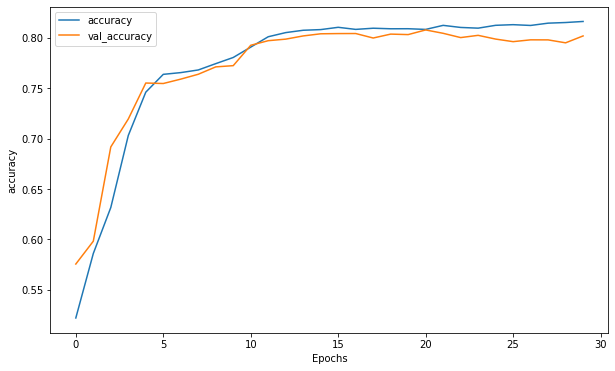

In [ ]:
plot_history(history, 'accuracy')

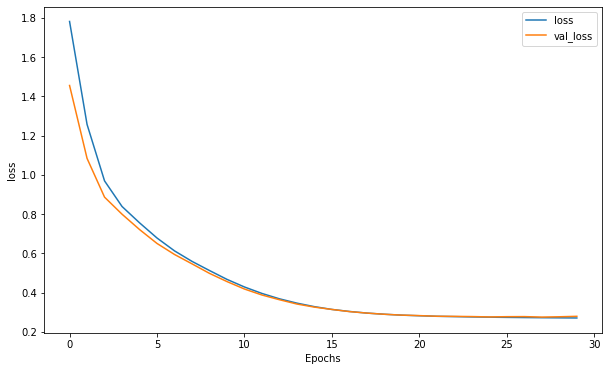

In [ ]:
plot_history(history, 'loss')

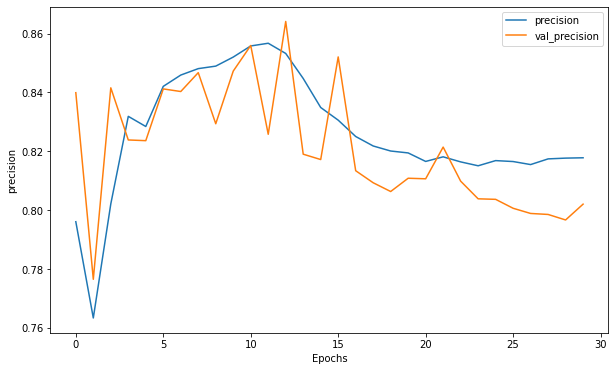

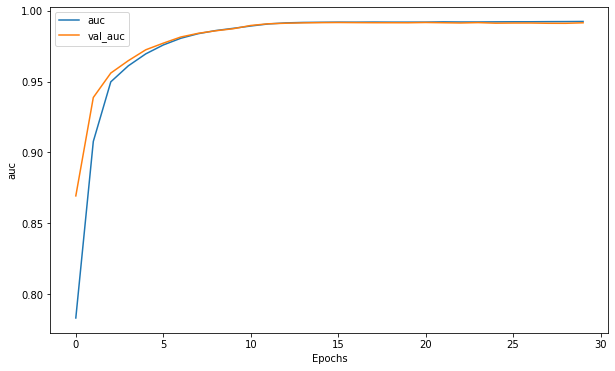

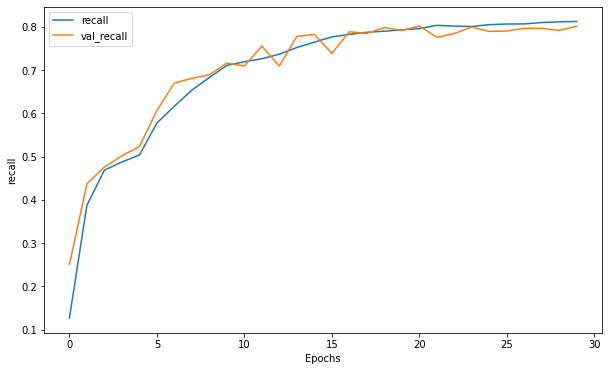

In [ ]:
plot_history(history, 'precision')
plot_history(history, 'auc')
plot_history(history, 'recall')